In [ ]:
# Imports
import pandas as pd
import numpy as np
import sys
import importlib

from skpp import ProjectionPursuitRegressor

sys.path.append("../tfti")
sys.path.append("../shapley")
import shapley
importlib.reload(shapley)

# plotting
import matplotlib.pyplot as pl

# plotting
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

# Code for parsing auROC files and running Shapley analysis

This notebook loads in auROC values produced from ../tfti/save_auc_shapley.py and runs a Shapley analysis.


## Load in text files

In [ ]:
################## User Configures ##################

# location of auROC values for mark sets
auc_text_filename = '/home/eecs/akmorrow/tfti/tfti/shapley_values_64_25_gm12878_depth_5_19.txt'

In [ ]:
auc_values = pd.read_csv(auc_text_filename, sep='\t')

In [ ]:
mark_sets = auc_values['permutation']

def split_marks(mark_str):
    """ Splits marks in test file to list of names
    :param mark_str string of marks, of format "['ATF2', 'CEBPB']"
    """
    for ch in ["'",'[',']'," "]:
        mark_str=mark_str.replace(ch,"")
        
    if (len(mark_str) == 0):
        return []
    return mark_str.split(',')

def R_ordering_from_marks(subset_marks, R_orderings, marks):
    """
    """
    index = []
    for i in subset_marks:
        index.append(marks.index(i))
    index = sorted(index)
    return list(filter(lambda x: x[1] == index, R_orderings))[0]

## Run Shapley Analysis Estimation using MSA

Next, we compute the Shapley values on predicted value functions using the MSA algorithm. The main idea is that we do not need to compute all instances of the value function. Instead, we will only compute a subset of instances and use these to predict the missing value functions. This is useful because in our case, the value function is prediction the model and we have many TFs to predict on.

Running on all 35 factors would require 35 million, so we choose a 19 sized subset that are used in the muticell analysis.

In [ ]:
selected_marks = ['CEBPB', 'CHD2', 'CTCF', 'DNase', 'EZH2', 'GABP', 'JunD', 'Max', 'Mxi1', 
                  'NRSF', 'Nrf1', 'Pol2', 'RFX5', 'Rad21', 'TAF1', 'TBP', 'USF2', 'c-Myc', 
                  'p300']


In [ ]:
auc_values

In [ ]:
# get singleton marks, which gives us a list of all players
# all 35 marks that are used to evaluate
marks = list(map(lambda x: split_marks(x), auc_values['permutation']))

# all 19 marks that are used in Shapley analysis
singleton_marks = list(filter(lambda x: (len(x) == 1) and (x[0] in selected_marks), marks))
singleton_marks = [item for sublist in singleton_marks  for item in sublist]

# TODO dict is used for ?
singleton_marks_dict = dict((y, x) for x, y in enumerate(singleton_marks))
singleton_marks_dict

In [ ]:
# Create all possible orderings of the players
orderedList = [i for i in range(len(selected_marks))]

depth = 4 # len(selected_marks)


# TODO why do you need both?
R_orderings = list(enumerate(shapley.power_set(orderedList)))
# smaller depth to decrease complexity
R_orderings_sampled = list(filter(lambda x: len(x[1]) <= depth, R_orderings))

In [ ]:
# define the characteristic function
characteristic_function = np.zeros(len(R_orderings_sampled))

In [ ]:
# generate X matrix and y labels for projection pursuit regression
sample_size = 0
projection_train_data=np.zeros((0,len(selected_marks)))
y=[]

# fill each row in the train data
for i, row in auc_values.iterrows():
    index_marks = split_marks(row['permutation'])
    if (set(index_marks).issubset(selected_marks)):
        # make new row
        new_row = np.zeros((1, len(selected_marks)))
        for l in index_marks:
            new_row[0, singleton_marks_dict[l]] = 1
        projection_train_data = np.append(projection_train_data, new_row, axis=0)
        y.append(row['averageAuROC'])
        
        # TODO index to char function
        index = R_ordering_from_marks(index_marks, R_orderings_sampled, selected_marks)[0]
        characteristic_function[index] = row['averageAuROC']
        sample_size += 1
                           
print(f"Using {sample_size} samples")
        
    

In [ ]:
# build a matrix that is #random calcs by len(players)  and predict on v
estimator = ProjectionPursuitRegressor()
estimator.fit(projection_train_data, y)

In [ ]:
# predict the missing characteristic values
print(f"prediction {len(R_orderings_sampled)-sample_size} predictions...")

predicted = 0

for x in R_orderings_sampled:
    # if we havent computed the characteristic function, compute it
    if (characteristic_function[[x[0]]] == 0):
        prediction_vector = np.zeros(len(singleton_marks))
        prediction_vector[x[1]] = 1
        characteristic_function[x[0]] = estimator.predict(np.matrix(prediction_vector))
        if (predicted % 10000 == 0):
            print(f"\tPredicted {predicted} out of {len(R_orderings_sampled)-sample_size} predictions")
        predicted += 1


In [ ]:
# compute the actual Shapley value
importlib.reload(shapley)
value_function = list(map(lambda x: x - characteristic_function[0], characteristic_function))
shapleys = shapley.compute_shapley_values_1d(singleton_marks, characteristic_function, depth=depth)

## Figure for 1D Shapley Analysis


### 1-D Shapley Analysis

DNase, CHD2, and p300 are highest contributors.
- Dnase is expected
- CHD2: chromatin organization modifier
- p300: chromatin remodeling via Histone acetyltransferases 
- CTCF: chromatin architecture
- Rfx5: immune related?

Lowest contributors
- Myc-c: global chromatin structure



In [ ]:
N = len(shapleys)

ind = np.arange(N)  # the x locations for the groups
width = 0.35        # the width of the bars

fig, ax1 = plt.subplots()
rects1 = ax1.bar(ind, shapleys, width, color='r')
ax1.set_ylabel('Shapley Value')
# ax.set_title('Shapley Values and auROC')
ax1.set_xticks(ind + width / 2)
ax1.set_xticklabels(selected_marks, rotation='vertical')
ax1.set_ylim([0,max(shapleys)+.001])

ax2 = ax1.twinx()
masked_auc_single = auc_values['maskedAverageAuROC'][1:20]

rects2 = ax2.bar(ind + width, masked_auc_single, width, color='y')

# add some text for labels, title and axes ticks
ax2.set_ylabel('auROC')
ax2.set_yscale('log')
ax2.grid(False)
ax1.legend((rects1[0], rects2[0]), ('Shapley', 'auROC'))

fig.tight_layout()
plt.show()

## 2D Shapley Analysis

In [ ]:
# compute the actual Shapley value
import importlib
importlib.reload(shapley)

def get_int(v, v0):
    if (v == v0):
        return 0
    elif (v > v0):
        return 1
    else:
        return -1 
    
value_function = list(map(lambda x: (x - characteristic_function[0])*100, characteristic_function))

shapleys_2d = shapley.compute_shapley_values_2d(singleton_marks, value_function, depth=depth)

## Plot 2-D Shapley Matrix

In [189]:

matrix_data = list(map(lambda x: x[1], shapleys_2d[0]))
shapley_matrix = np.zeros((len(selected_marks), len(selected_marks)))
indices = np.tril_indices(len(selected_marks),-1)
shapley_matrix[indices] = matrix_data    


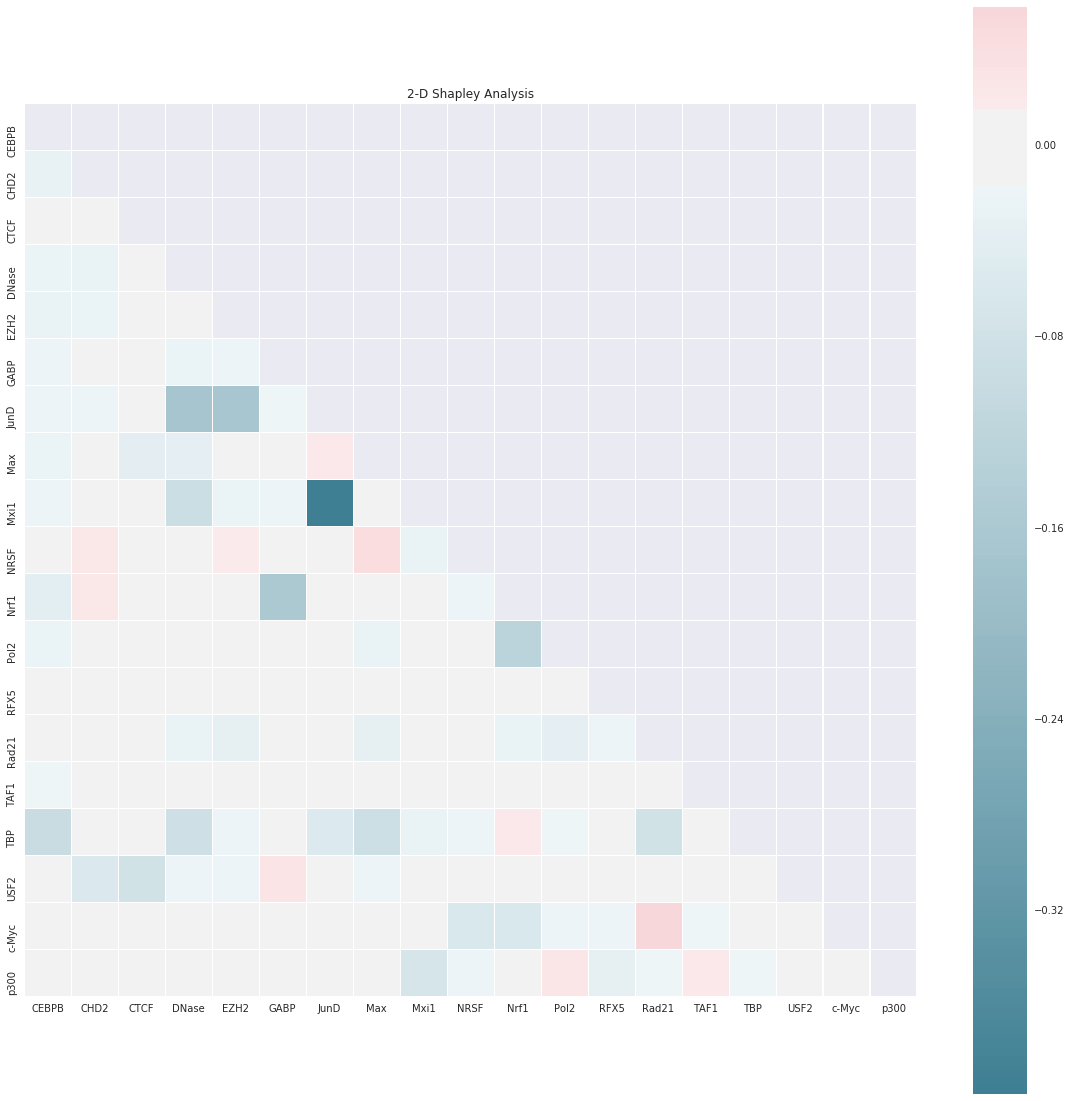

In [190]:

# Generate a mask for the upper triangle
mask = np.zeros_like(shapley_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

ax.set_title("2-D Shapley Analysis")

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(shapley_matrix,mask=mask, yticklabels=selected_marks,xticklabels=selected_marks, cmap=cmap,center=0,
            square=True, linewidths=0.05)

## Plotting information from 2D Shapley

In [186]:

matrix_data = list(map(lambda x: x[1], shapleys_2d[1]))
shapley_matrix = np.zeros((len(selected_marks), len(selected_marks)))
indices = np.tril_indices(len(selected_marks),-1)
shapley_matrix[indices] = matrix_data 

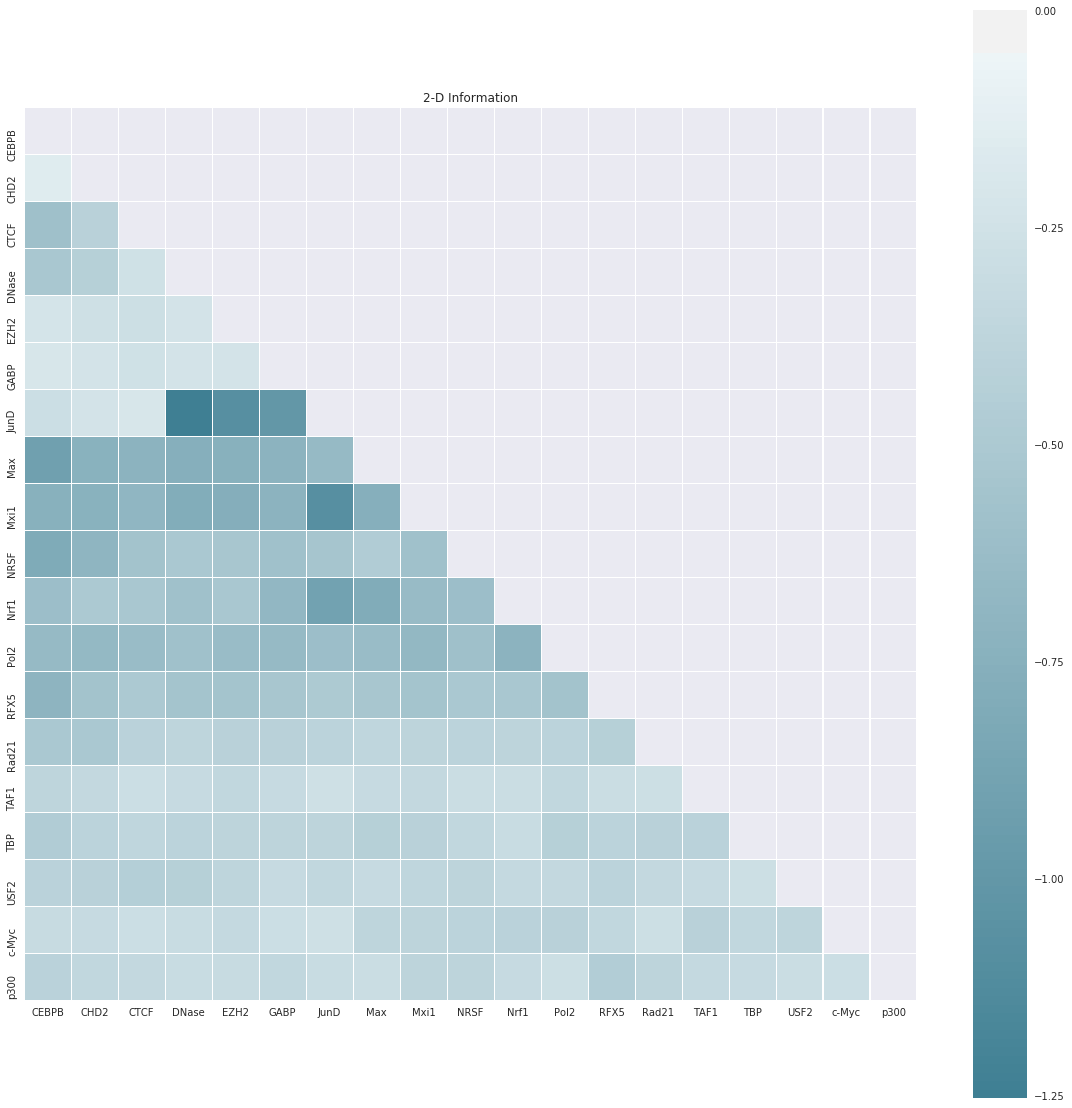

In [187]:
# Generate a mask for the upper triangle
mask = np.zeros_like(shapley_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

ax.set_title("2-D Information")

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = sns.heatmap(shapley_matrix,mask=mask, yticklabels=selected_marks,xticklabels=selected_marks, cmap=cmap,center=0,
            square=True, linewidths=0.05)